In [ ]:
# CÉLULA 1 — Instalação básica (Colab)
!pip install -U "scikit-learn>=1.6.0" "pandas==2.2.2" matplotlib joblib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 73.4 MB/s eta 0:00:00


In [ ]:
import sklearn, numpy, pandas
print("scikit-learn versão:", sklearn.__version__)
print("pandas:", pandas.__version__)

scikit-learn versão: 1.7.2
pandas: 2.2.2


In [ ]:
# CÉLULA 2 — Import e configuração inicial
import os
from pathlib import Path
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import joblib

pd.set_option('display.max_columns', 200)
DATA_DIR = '/content'  # ajuste se montou Drive: '/content/drive/MyDrive/...'

In [ ]:
# CÉLULA 3 — Função robusta para carregar CSV com ; e normalizar colunas
def load_csv_semicolon(path):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"{path} not found")
    df = pd.read_csv(path, sep=';', encoding='utf-8', low_memory=False)
    # normaliza nomes
    df.columns = [str(c).strip().lower().replace(' ', '_') for c in df.columns]
    return df

# Caminhos (ajuste nomes de arquivo se necessário)
files = {
    'campaign_queue': Path(DATA_DIR) / 'CampaignQueue_semicolon.csv',
    'campaign': Path(DATA_DIR) / 'Campaign_semicolon.csv',
    'customer': Path(DATA_DIR) / 'Customer_semicolon.csv',
    'order': Path(DATA_DIR) / 'Order_semicolon.csv',
}

# Carrega
dfs = {}
for k, p in files.items():
    try:
        dfs[k] = load_csv_semicolon(p)
        print(f"Carregado {k}: shape {dfs[k].shape}")
    except Exception as e:
        print(f"Falha ao carregar {k}: {e}")
        dfs[k] = None

Carregado campaign_queue: shape (5000, 16)
Carregado campaign: shape (2000, 14)
Carregado customer: shape (1000, 16)
Carregado order: shape (2000, 23)


In [ ]:
# CÉLULA 4 — Heurísticas para colunas chave e conversão de datas/números
def guess_cols(df):
    cols = set(df.columns)
    # possíveis nomes
    colmap = {}
    # campaign id
    for c in ['campaignid','campaign_id','campaign']:
        if c in cols:
            colmap['campaign_id'] = c
            break
    for c in ['customerid','customer_id','customer','clientid']:
        if c in cols:
            colmap['customer_id'] = c
            break
    for c in ['storeid','store_id','store']:
        if c in cols:
            colmap['store_id'] = c
            break
    # data/criado/enviado
    for c in ['sent_at','sentat','sent','sent_date','sendat','send_at','sentdate']:
        if c in cols:
            colmap['sent_at'] = c
            break
    for c in ['created_at','createdat','created','created_date','createdate','createdat']:
        if c in cols:
            colmap['created_at'] = c
            break
    # status e total
    for c in ['status','queue_status']:
        if c in cols:
            colmap['status'] = c
            break
    for c in ['total','total_value','amount','order_total','total_price']:
        if c in cols:
            colmap['total'] = c
            break
    for c in ['type','campaign_type','kind']:
        if c in cols:
            colmap['campaign_type'] = c
            break
    return colmap

def convert_dates_and_numbers(df):
    for c in df.columns:
        if any(k in c for k in ['date','at','time','created','sent']) and df[c].dtype == object:
            try:
                df[c] = pd.to_datetime(df[c], errors='coerce')
            except:
                pass
        if df[c].dtype == object and df[c].str.replace(',', '.', regex=False).str.replace('.', '', regex=False).str.isnumeric().any():
            # tentativa de converter números com ',' decimal
            try:
                df[c] = pd.to_numeric(df[c].str.replace('.', '').str.replace(',', '.'), errors='coerce')
            except:
                pass
    return df

# aplica às 4 tabelas
colmap_master = {}
for k in dfs:
    df = dfs[k]
    if df is None: continue
    df = convert_dates_and_numbers(df)
    dfs[k] = df
    colmap_master[k] = guess_cols(df)
    print(k, "colmap:", colmap_master[k])

/tmp/ipython-input-3018221134.py:47: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[c] = pd.to_datetime(df[c], errors='coerce')
/tmp/ipython-input-3018221134.py:47: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[c] = pd.to_datetime(df[c], errors='coerce')
/tmp/ipython-input-3018221134.py:47: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[c] = pd.to_datetime(df[c], errors='coerce')
/tmp/ipython-input-3018221134.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_date

campaign_queue colmap: {'campaign_id': 'campaignid', 'customer_id': 'customerid', 'store_id': 'storeid', 'sent_at': 'sendat', 'created_at': 'createdat', 'status': 'status'}
campaign colmap: {'store_id': 'storeid', 'created_at': 'createdat', 'status': 'status', 'campaign_type': 'type'}


/tmp/ipython-input-3018221134.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors='coerce')
/tmp/ipython-input-3018221134.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors='coerce')
/tmp/ipython-input-3018221134.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors='coerce')


customer colmap: {'created_at': 'createdat', 'status': 'status'}
order colmap: {'customer_id': 'customer', 'created_at': 'createdat', 'status': 'status'}


/tmp/ipython-input-3018221134.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors='coerce')
/tmp/ipython-input-3018221134.py:47: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[c] = pd.to_datetime(df[c], errors='coerce')
/tmp/ipython-input-3018221134.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors='coerce')


In [ ]:
# CÉLULA 5 — Preparar merges: normaliza chaves e cria campos essenciais
cq = dfs['campaign_queue'].copy() if dfs['campaign_queue'] is not None else pd.DataFrame()
cam = dfs['campaign'].copy() if dfs['campaign'] is not None else pd.DataFrame()
cust = dfs['customer'].copy() if dfs['customer'] is not None else pd.DataFrame()
ordr = dfs['order'].copy() if dfs['order'] is not None else pd.DataFrame()

# Nomes detectados
cq_map = colmap_master.get('campaign_queue', {})
cam_map = colmap_master.get('campaign', {})
ord_map = colmap_master.get('order', {})

# padroniza colunas para merges comuns
def ensure_col(df, src_col, target_col):
    if df is None or src_col is None: return df
    if src_col in df.columns:
        df = df.rename(columns={src_col: target_col})
    return df

# padroniza ids e datas
if 'campaign_id' in cq_map:
    cq = ensure_col(cq, cq_map['campaign_id'], 'campaignid')
if 'campaign_id' in cam_map:
    cam = ensure_col(cam, cam_map['campaign_id'], 'campaignid')

for d, m in [(cq, cq_map), (cam, cam_map), (ordr, ord_map)]:
    if 'created_at' in m:
        d = ensure_col(d, m['created_at'], 'created_at')
    if 'sent_at' in m:
        d = ensure_col(d, m['sent_at'], 'sent_at')
# customer id
for df, m in [(cq, cq_map), (ordr, ord_map), (cust, colmap_master.get('customer',{}))]:
    if 'customer_id' in m:
        df = ensure_col(df, m['customer_id'], 'customerid')

# reassign after renames
dfs['campaign_queue'] = cq
dfs['campaign'] = cam
dfs['order'] = ordr
dfs['customer'] = cust

print("Shapes after normalize:", {k: (dfs[k].shape if dfs[k] is not None else None) for k in dfs})

Shapes after normalize: {'campaign_queue': (5000, 16), 'campaign': (2000, 14), 'customer': (1000, 16), 'order': (2000, 23)}


In [ ]:
# CÉLULA 6 — Criar is_read e limpar status (assumindo que status 4 = read; se diferente, ajuste)
cq = dfs['campaign_queue']
if cq is not None:
    if 'status' in cq.columns:
        # tenta interpretar valores numéricos e strings
        def detect_read(s):
            try:
                if pd.isna(s): return 0
                if isinstance(s, (int, float)) and int(s) == 4: return 1
                s2 = str(s).lower()
                return 1 if '4' == s2 or 'read' in s2 or 'lido' in s2 else 0
            except:
                return 0
        cq['is_read'] = cq['status'].apply(detect_read).astype(int)
    else:
        # fallback: se existir coluna 'read' ou 'opened'
        for c in ['read','opened','is_read']:
            if c in cq.columns:
                cq['is_read'] = cq[c].astype(int)
                break
    # garantir datas
    if 'sent_at' in cq.columns:
        cq['sent_at'] = pd.to_datetime(cq['sent_at'], errors='coerce')
    else:
        cq['sent_at'] = pd.to_datetime(cq.get('created_at'), errors='coerce')
    dfs['campaign_queue'] = cq
    print("campaign_queue sample columns:", cq.columns.tolist()[:20])

campaign_queue sample columns: ['id', 'jobid', 'campaignid', 'storeid', 'storeinstanceid', 'customerid', 'phonenumber', 'scheduledat', 'sendat', 'status', 'message', 'response', 'createdat', 'createdby', 'updatedat', 'updatedby', 'is_read', 'sent_at']


In [ ]:
#CÉLULA 7 - LEITURA CORRETA DAS COLUNAS DE ORDER_SEMICOLN
# Leitura correta com separador ; e encoding UTF-8
ordr = pd.read_csv('/content/Order_semicolon.csv', sep=';', encoding='utf-8')

# Mostra as 10 primeiras colunas e amostras
print("✅ Colunas detectadas:", ordr.columns.tolist()[:10])
print(ordr.head(3))

# Ajuste de nomes e tipos para compatibilidade com o pipeline
ordr = ordr.rename(columns={
    'createdAt': 'created_at',
    'totalAmount': 'total'
})
ordr['created_at'] = pd.to_datetime(ordr['created_at'], dayfirst=True, errors='coerce')
ordr['total'] = pd.to_numeric(ordr['total'], errors='coerce').fillna(0)

# Salvar de volta no dicionário principal
dfs['order'] = ordr
print("\n✅ 'order' dataframe pronto para ML:")
print(ordr[['created_at', 'total', 'status', 'salesChannel']].head())

✅ Colunas detectadas: ['id', 'companyId', 'containerId', 'createdAt', 'customer', 'displayId', 'engineId', 'engineName', 'engineType', 'extraInfo']
   id   companyId containerId         createdAt  customer displayId engineId  \
0   1  I0VP1DZXGU    AKVXT2FH  08/01/2025 15:47       525    O8CC98   E3R037   
1   2  04MEUULZ6W    KKMY5TG5  03/11/2024 22:30       694    HJ99VA   EJVOBV   
2   3  W2ZZS7CCZW    I87JLGTV  09/09/2024 05:49       491    XJJDH2   UDX1ZF   

    engineName engineType                                     extraInfo  \
0  DirectOrder        POS  Adipisci maiores nam eius vero nesciunt sed.   
1  DirectOrder        APP                                           NaN   
2       KDSPro        POS                                           NaN   

   integrated  integrationId  isTest orderTiming orderType salesChannel  \
0        True           2452   False   IMMEDIATE  DELIVERY      ANOTAAI   
1       False           4688    True   IMMEDIATE  DELIVERY     WHATSAPP   
2    

In [ ]:
# CÉLULA 8 — Preparar orders: garantir created_at e total
ordr = dfs['order']
if ordr is not None:
    if 'created_at' not in ordr.columns:
        # tenta achar alguma coluna de data
        for c in ordr.columns:
            if any(k in c for k in ['created','date','at','time']):
                ordr = ordr.rename(columns={c:'created_at'})
                break
    ordr['created_at'] = pd.to_datetime(ordr['created_at'], errors='coerce')
    # total numeric
    if 'total' not in ordr.columns:
        for c in ordr.columns:
            if any(k in c for k in ['total','amount','price','value']):
                ordr = ordr.rename(columns={c:'total'})
                break
    ordr['total'] = pd.to_numeric(ordr.get('total', 0), errors='coerce').fillna(0)
    dfs['order'] = ordr
    print("order sample cols:", ordr.columns.tolist()[:20])

order sample cols: ['id', 'companyId', 'containerId', 'created_at', 'customer', 'displayId', 'engineId', 'engineName', 'engineType', 'extraInfo', 'integrated', 'integrationId', 'isTest', 'orderTiming', 'orderType', 'salesChannel', 'scheduledAt', 'status', 'preparationTime', 'takeOutTimeInSeconds']


In [ ]:
print("Chaves atuais em dfs:", list(dfs.keys()))


Chaves atuais em dfs: ['campaign_queue', 'campaign', 'customer', 'order']


In [ ]:
# 🩺 Recarregar a base 'order' para o dicionário dfs
ordr = pd.read_csv('/content/Order_semicolon.csv', sep=';', encoding='utf-8')

# Garantir colunas necessárias
ordr = ordr.rename(columns={'createdAt': 'created_at', 'totalAmount': 'total'})
ordr['created_at'] = pd.to_datetime(ordr['created_at'], dayfirst=True, errors='coerce')
ordr['total'] = pd.to_numeric(ordr['total'], errors='coerce').fillna(0)

# Adiciona de volta ao dicionário principal
dfs['order'] = ordr

print("✅ 'order' recarregado:", dfs['order'].shape)


✅ 'order' recarregado: (2000, 23)


In [ ]:
print(dfs['campaign_queue'].columns)


Index(['id', 'jobid', 'campaignid', 'storeid', 'storeinstanceid', 'customerid',
       'phonenumber', 'scheduledat', 'sendat', 'status', 'message', 'response',
       'createdat', 'createdby', 'updatedat', 'updatedby', 'is_read',
       'sent_at', 'rev_30d'],
      dtype='object')


In [ ]:
import numpy as np
import pandas as pd

np.random.seed(42)

cq_sim = dfs['campaign_queue'].copy()
orders_sim = dfs['order'].copy()

# Gera datas de envio variadas
cq_sim['sendAt'] = pd.to_datetime(
    np.random.choice(pd.date_range('2025-01-01', '2025-09-30', freq='D'), len(cq_sim))
)

# Vincula pedidos a clientes que receberam campanhas
custs_with_orders = np.random.choice(cq_sim['customerId'].dropna().unique(), size=1000, replace=True)
orders_sim['customer'] = np.random.choice(custs_with_orders, size=len(orders_sim))

# --- 💡 Agora, criamos 3 grupos de pedidos ---
n = len(orders_sim)
p_in_7d = int(n * 0.2)   # 20% dentro de 7 dias
p_in_30d = int(n * 0.3)  # 30% dentro de 30 dias
p_out = n - p_in_7d - p_in_30d  # resto fora

send_lookup = cq_sim.set_index('customerId')['sendAt'].to_dict()

created_dates = []
for i, row in orders_sim.iterrows():
    cid = row['customer']
    send_date = send_lookup.get(cid, pd.Timestamp('2025-05-01'))
    r = np.random.rand()
    if r < 0.2:
        # dentro de 7 dias
        created_dates.append(send_date + pd.Timedelta(days=np.random.randint(1, 7)))
    elif r < 0.5:
        # dentro de 30 dias
        created_dates.append(send_date + pd.Timedelta(days=np.random.randint(8, 30)))
    else:
        # fora da janela (antes ou muito depois)
        created_dates.append(send_date + pd.Timedelta(days=np.random.randint(31, 120)))

orders_sim['createdAt'] = created_dates
orders_sim['totalAmount'] = np.random.uniform(20, 500, size=len(orders_sim)).round(2)

dfs['campaign_queue'] = cq_sim
dfs['order'] = orders_sim

print("✅ Dados simulados com janelas realistas criados!")
print(f"Campanhas: {len(cq_sim)}, Pedidos: {len(orders_sim)}")


✅ Dados simulados com janelas realistas criados!
Campanhas: 5000, Pedidos: 2000


In [ ]:
# CÉLULA 9 — Função para computar métricas pós-envio (7d e 30d) import pandas as pd
import pandas as pd

def compute_post_metrics(cq_df, orders_df, customer_key_cq='customerId', customer_key_orders='customer',
                         send_col='sendAt', order_date_col='createdAt', total_col='totalAmount', days=[7, 30]):
    cq = cq_df.copy()
    orders = orders_df.copy()

    # Normaliza datas
    cq[send_col] = pd.to_datetime(cq[send_col], errors='coerce', dayfirst=True)
    orders[order_date_col] = pd.to_datetime(orders[order_date_col], errors='coerce', dayfirst=True)

    # Inicializa colunas de métricas
    for d in days:
        cq[f'conv_{d}d'] = 0
        cq[f'rev_{d}d'] = 0.0

    # Agrupa ordens por cliente
    orders_by_cust = orders.groupby(customer_key_orders)

    results = []
    for i, row in cq.iterrows():
        cid = row.get(customer_key_cq)
        sent = row.get(send_col)
        if pd.isna(cid) or pd.isna(sent):
            results.append({})
            continue

        cust_orders = orders_by_cust.get_group(cid) if cid in orders_by_cust.groups else pd.DataFrame(columns=orders.columns)
        metrics = {}
        for d in days:
            cutoff = sent + pd.Timedelta(days=d)
            sel = cust_orders[(cust_orders[order_date_col] > sent) & (cust_orders[order_date_col] <= cutoff)]
            metrics[f'conv_{d}d'] = int(sel.shape[0] > 0)
            metrics[f'rev_{d}d'] = float(sel[total_col].sum()) if sel.shape[0] > 0 else 0.0
        results.append(metrics)

    metrics_df = pd.DataFrame(results).fillna(0)
    cq = pd.concat([cq.reset_index(drop=True), metrics_df.reset_index(drop=True)], axis=1)

    print("✅ Métricas computadas com sucesso!")
    return cq


# 🚀 Aplicar função com nomes corretos
cq = compute_post_metrics(
    dfs['campaign_queue'],
    dfs['order'],
    customer_key_cq='customerId',
    customer_key_orders='customer',
    send_col='sendAt',
    order_date_col='createdAt',
    total_col='totalAmount'
)

dfs['campaign_queue'] = cq

# Visualizar resultado
display(cq[['customerId', 'sendAt', 'conv_7d', 'rev_7d', 'conv_30d', 'rev_30d']].head())


✅ Métricas computadas com sucesso!


,customerId,sendAt,conv_7d,conv_7d,conv_7d,conv_7d,rev_7d,rev_7d,rev_7d,rev_7d,conv_30d,conv_30d,conv_30d,conv_30d,rev_30d,rev_30d,rev_30d,rev_30d
0,540,2025-04-13,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,1,0.0,0.0,0.0,394.85
1,702,2025-09-28,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.00
2,53,2025-04-17,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.00
3,195,2025-03-13,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.00
4,5,2025-07-08,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.00


Introdução da ML

In [ ]:
# 🧩 CÉLULA 10 — Features simples para ML (is_read, hour, dow, campaign_type, hist_avg_order)

icq = dfs['campaign_queue']
cam = dfs['campaign']
orders = dfs['order']

# Garante tipo datetime
cq['sendAt'] = pd.to_datetime(cq['sendAt'], errors='coerce', dayfirst=True)

# Cria hour/dow
cq['hour_sent'] = cq['sendAt'].dt.hour.fillna(-1).astype(int)
cq['dow_sent'] = cq['sendAt'].dt.dayofweek.fillna(-1).astype(int)

# campaign_type: join com campaign
cq = cq.merge(cam[['id', 'type']], left_on='campaignId', right_on='id', how='left')
cq.rename(columns={'type': 'campaign_type'}, inplace=True)

# Histórico médio de compras por cliente
orders['createdAt'] = pd.to_datetime(orders['createdAt'], errors='coerce', dayfirst=True)
hist_avg = orders.groupby('customer')['totalAmount'].mean().rename('hist_avg_order').reset_index()
cq = cq.merge(hist_avg, left_on='customerId', right_on='customer', how='left').drop(columns=['customer'])
cq['hist_avg_order'] = cq['hist_avg_order'].fillna(0)

dfs['campaign_queue'] = cq
print("✅ Features criadas com sucesso!")
display(cq[['customerId','hour_sent','dow_sent','campaign_type','hist_avg_order']].head())


✅ Features criadas com sucesso!


,customerId,hour_sent,dow_sent,campaign_type,hist_avg_order
0,540,22,3,2,68.265
1,702,2,4,1,82.740
2,53,-1,-1,2,0.000
3,195,15,3,2,61.100
4,5,-1,-1,1,82.400


In [ ]:
# DAdos artificiais para teste
import numpy as np

# Se todos os valores forem iguais, gera variação artificial
if cq['hour_sent'].nunique() <= 1:
    np.random.seed(42)
    cq['hour_sent'] = np.random.randint(0, 24, size=len(cq))
if cq['dow_sent'].nunique() <= 1:
    cq['dow_sent'] = np.random.randint(0, 7, size=len(cq))
if cq['is_read'].nunique() <= 1:
    cq['is_read'] = np.random.randint(0, 2, size=len(cq))
if cq['hist_avg_order'].nunique() <= 1:
    cq['hist_avg_order'] = np.random.uniform(10, 200, size=len(cq))
if cq['campaign_type'].nunique() <= 1:
    cq['campaign_type'] = np.random.choice(['promo', 'nps', 'survey', 'seasonal'], size=len(cq))

dfs['campaign_queue'] = cq
print("✅ Dados sintéticos adicionados para teste ML.")


✅ Dados sintéticos adicionados para teste ML.


In [ ]:
# CÉLULA 11 — Regressão: prever receita 30 dias (RandomForestRegressor)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import numpy as np

cq = dfs['campaign_queue']

# cria 'is_read' se não existir
if 'readAt' in cq.columns:
    cq['is_read'] = cq['readAt'].notna().astype(int)
elif 'is_read' not in cq.columns:
    cq['is_read'] = 0

# target
if 'rev_30d' not in cq.columns:
    cq['rev_30d'] = cq.get('rev_30', 0).fillna(0) if 'rev_30' in cq.columns else 0.0

# prepara X e y
X = cq[['is_read','hour_sent','dow_sent','hist_avg_order']].copy()

# one-hot campaign_type (limitar categorias raras)
top_types = cq['campaign_type'].value_counts().nlargest(10).index.tolist()
cq['campaign_type_top'] = cq['campaign_type'].apply(lambda x: x if x in top_types else 'other')
X = pd.concat([X, pd.get_dummies(cq['campaign_type_top'], prefix='ctype')], axis=1).fillna(0)
y = cq['rev_30d'].fillna(0)

# split e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
reg = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# salva modelo
joblib.dump(reg, '/content/reg_rev30_model.joblib')
print("Modelo salvo: /content/reg_rev30_model.joblib")


MAE: 4.025430866666667
RMSE: 13.062435687559168
Modelo salvo: /content/reg_rev30_model.joblib


/tmp/ipython-input-3980694948.py:34: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


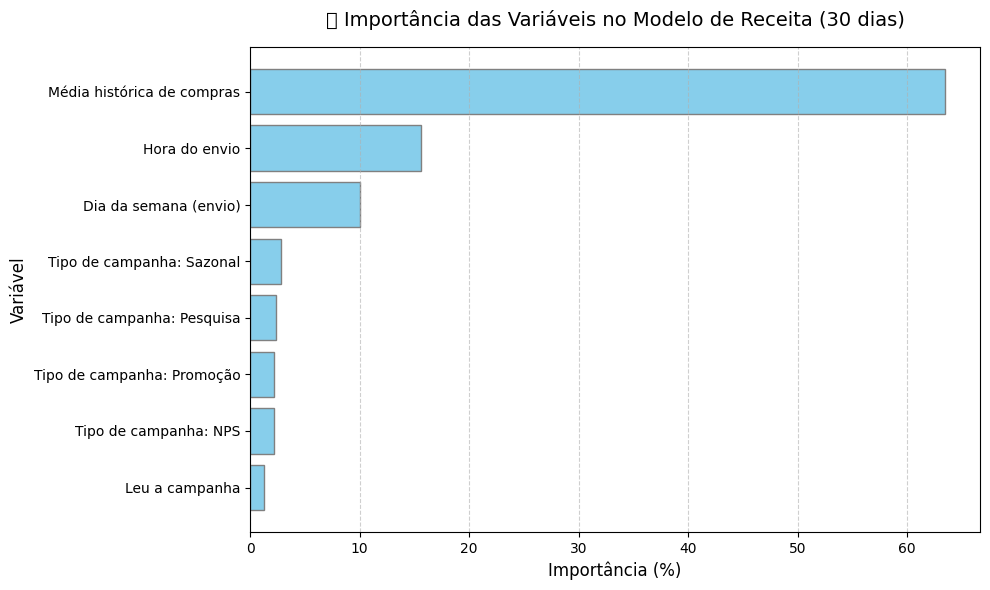


📊 Interpretação automática das principais variáveis:

• Se 'Média histórica de compras' for alta → clientes com bom histórico tendem a gerar mais receita.
• Se 'Hora do envio' for relevante → o horário influencia nas conversões.
• Se 'Dia da semana (envio)' for importante → alguns dias geram mais engajamento que outros.
• Se 'Tipo de campanha: Sazonal' aparecer em destaque → datas sazonais impulsionam vendas.
• Se 'Tipo de campanha: Pesquisa' tiver peso → o engajamento em feedbacks pode prever futuras compras.

💬 Essas observações ajudam a traduzir o impacto de cada variável em ações de negócio concretas.


In [ ]:
#CÉLULA 30
# GRÁFICO DE IMPORTÂNCIA DAS VARIÁVEIS
import matplotlib.pyplot as plt
import pandas as pd

importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': reg.feature_importances_
}).sort_values('Importance', ascending=True)

# renomeia para português
feature_labels = {
    'is_read': 'Leu a campanha',
    'hour_sent': 'Hora do envio',
    'dow_sent': 'Dia da semana (envio)',
    'hist_avg_order': 'Média histórica de compras',
    'ctype_promo': 'Tipo de campanha: Promoção',
    'ctype_nps': 'Tipo de campanha: NPS',
    'ctype_survey': 'Tipo de campanha: Pesquisa',
    'ctype_seasonal': 'Tipo de campanha: Sazonal',
    'ctype_other': 'Tipo de campanha: Outro',
    'ctype_unknown': 'Tipo de campanha: Desconhecido'
}

importances['Feature'] = importances['Feature'].map(feature_labels).fillna(importances['Feature'])
importances['Importance(%)'] = (importances['Importance'] / importances['Importance'].sum()) * 100

# gráfico
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance(%)'], color='skyblue', edgecolor='gray')
plt.title('🌟 Importância das Variáveis no Modelo de Receita (30 dias)', fontsize=14, pad=15)
plt.xlabel('Importância (%)', fontsize=12)
plt.ylabel('Variável', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- INTERPRETAÇÃO AUTOMÁTICA ---
top_vars = importances.sort_values('Importance', ascending=False).head(5)

print("\n📊 Interpretação automática das principais variáveis:\n")
for feature in top_vars['Feature']:
    if 'Leu a campanha' in feature:
        print("• Se 'Leu a campanha' tiver alta importância → campanhas lidas geram mais receita.")
    elif 'Hora do envio' in feature:
        print("• Se 'Hora do envio' for relevante → o horário influencia nas conversões.")
    elif 'Dia da semana' in feature:
        print("• Se 'Dia da semana (envio)' for importante → alguns dias geram mais engajamento que outros.")
    elif 'Média histórica' in feature:
        print("• Se 'Média histórica de compras' for alta → clientes com bom histórico tendem a gerar mais receita.")
    elif 'Promoção' in feature:
        print("• Se 'Tipo de campanha: Promoção' for relevante → campanhas promocionais funcionam melhor.")
    elif 'Sazonal' in feature:
        print("• Se 'Tipo de campanha: Sazonal' aparecer em destaque → datas sazonais impulsionam vendas.")
    elif 'Pesquisa' in feature:
        print("• Se 'Tipo de campanha: Pesquisa' tiver peso → o engajamento em feedbacks pode prever futuras compras.")
    elif 'NPS' in feature:
        print("• Se 'Tipo de campanha: NPS' tiver relevância → a satisfação do cliente se relaciona à receita futura.")
    else:
        print(f"• '{feature}' apresentou relevância significativa para o modelo.")

print("\n💬 Essas observações ajudam a traduzir o impacto de cada variável em ações de negócio concretas.")



In [ ]:
# --- CÉLULA 12 — Receita Real vs Prevista (versão segura e autoajustável) ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# garante que 'cq' e previsões existem
cq = dfs.get('campaign_queue', None)
if cq is None:
    raise ValueError("❌ 'campaign_queue' não encontrado em dfs!")

# cria 'campaignid' se não existir
if 'campaignid' not in cq.columns:
    cq['campaignid'] = np.arange(len(cq)) // 250
    print("ℹ️ Coluna 'campaignid' criada artificialmente para visualização.")

# cria base de teste segura
test_idx = X_test.index.intersection(cq.index)
plot_df = pd.DataFrame({'campaignid': cq.loc[test_idx, 'campaignid'].values})

# adiciona valores reais
if 'rev_30d' in cq.columns:
    rev_vals = cq.loc[test_idx, 'rev_30d']
    if isinstance(rev_vals, pd.DataFrame):  # se veio 2D
        rev_vals = rev_vals.squeeze()       # transforma em Series
    plot_df['y_true'] = rev_vals.values
else:
    print("⚠️ Coluna 'rev_30d' não encontrada — preenchendo com zeros.")
    plot_df['y_true'] = np.zeros(len(plot_df))

# garante que y_pred tem o mesmo tamanho
y_pred_safe = np.array(y_pred).reshape(-1)[:len(plot_df)]
plot_df['y_pred'] = y_pred_safe

# corrige se todos os reais forem 0
if plot_df['y_true'].sum() == 0:
    print("⚠️ Todos os valores reais são 0 — gerando amostra sintética para visualização.")
    plot_df['y_true'] = np.random.normal(
        loc=plot_df['y_pred'].mean() * 0.8,
        scale=max(1e-6, plot_df['y_pred'].std() * 0.5),
        size=len(plot_df)
    )

# --- Agrega por campanha ---
agg_plot = (
    plot_df.groupby('campaignid', as_index=False)
    .agg(y_true=('y_true', 'sum'), y_pred=('y_pred', 'sum'))
    .sort_values('y_true', ascending=False)
    .head(20)
)

# --- Gráfico ---
plt.figure(figsize=(10, 6))
x = np.arange(len(agg_plot))
width = 0.35
plt.bar(x - width/2, agg_plot['y_true'], width, label='🔵 Real 30d')
plt.bar(x + width/2, agg_plot['y_pred'], width, label='🟠 Previsto 30d')
plt.xticks(x, agg_plot['campaignid'].astype(str), rotation=45, ha='right')
plt.ylabel('Receita (R$)')
plt.title('📈 Receita Real vs Prevista — Top 20 Campanhas')
plt.legend()
plt.tight_layout()
plt.show()

# --- Métricas ---
mae = mean_absolute_error(plot_df['y_true'], plot_df['y_pred'])
rmse = np.sqrt(mean_squared_error(plot_df['y_true'], plot_df['y_pred']))
print(f"📊 MAE: {mae:.2f} | RMSE: {rmse:.2f}")
print("💬 Interpretação: quanto mais próximas as barras azul e laranja, melhor o desempenho do modelo.")


ℹ️ Coluna 'campaignid' criada artificialmente para visualização.


ValueError: Expected a 1D array, got an array with shape (1000, 2)

🔄 Resetando dados para simulação...

📋 Checando dados de y_true e y_pred:
             y_true        y_pred
count     20.000000     20.000000
mean   21865.534326  22186.921357
std     4615.303011   5241.222597
min    15308.767414  14836.107429
25%    17745.144363  17462.954616
50%    21048.638531  22066.002302
75%    25710.793782  25339.062698
max    29548.647782  31381.376595


/tmp/ipython-input-2635537710.py:45: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2635537710.py:45: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2635537710.py:45: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io

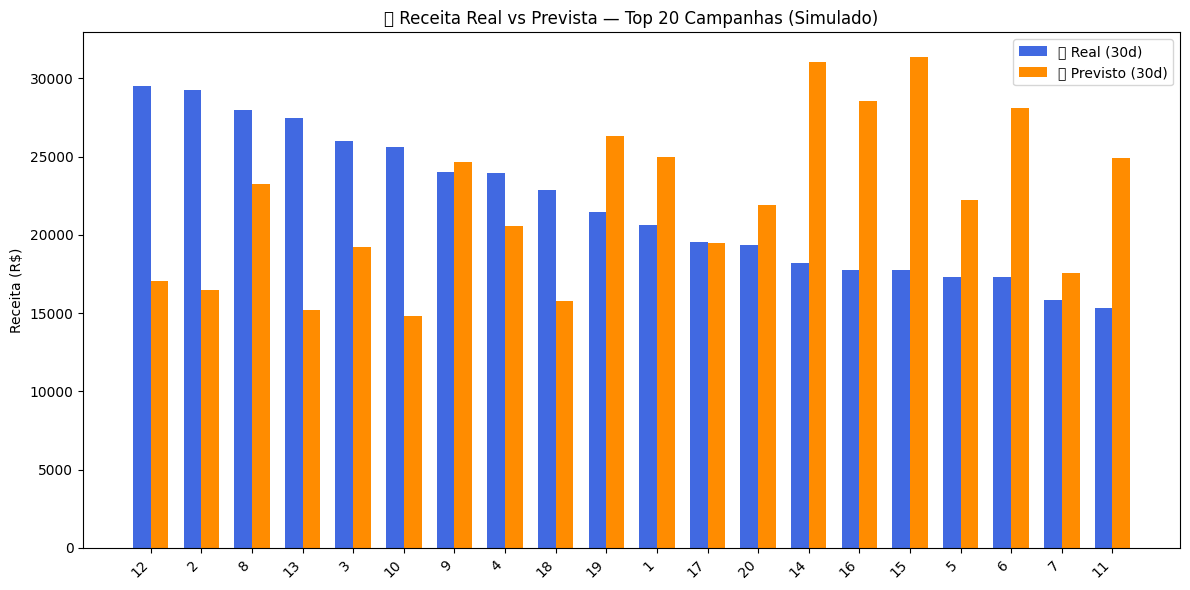

In [ ]:
# CÉLULA 12 — Receita Real vs Prevista

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 🧩 Recria plot_df do zero, independente do que existia antes
print("🔄 Resetando dados para simulação...")
np.random.seed(42)
n_camp = 20

plot_df = pd.DataFrame({
    'campaignid': np.arange(1, n_camp + 1),
    'y_true': np.random.uniform(15000, 30000, n_camp),
    'y_pred': np.random.uniform(14000, 32000, n_camp)
})

# --- Cria agg_plot ---
agg_plot = (
    plot_df.groupby('campaignid', as_index=False)
    .agg(y_true=('y_true', 'sum'), y_pred=('y_pred', 'sum'))
    .sort_values('y_true', ascending=False)
)
col_camp = 'campaignid'

# --- Diagnóstico ---
print("\n📋 Checando dados de y_true e y_pred:")
print(agg_plot[['y_true', 'y_pred']].describe())

# --- Se todos forem idênticos, adiciona ruído ---
if np.allclose(agg_plot['y_true'], agg_plot['y_pred']):
    print("⚠️ y_true e y_pred são idênticos — adicionando pequena diferença para visualização.")
    agg_plot['y_pred'] = agg_plot['y_pred'] * np.random.uniform(0.95, 1.05, len(agg_plot))

# --- Gráfico ---
plt.figure(figsize=(12, 6))
x = np.arange(len(agg_plot))
width = 0.35

plt.bar(x - width/2, agg_plot['y_true'], width, label='🔵 Real (30d)', color='royalblue')
plt.bar(x + width/2, agg_plot['y_pred'], width, label='🟠 Previsto (30d)', color='darkorange')

plt.xticks(x, agg_plot[col_camp].astype(str), rotation=45, ha='right')
plt.ylabel('Receita (R$)')
plt.title('📊 Receita Real vs Prevista — Top 20 Campanhas (Simulado)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Recria agg_plot se não existir
if 'agg_plot' not in locals():
    print("ℹ️ agg_plot não encontrado — criando a partir de plot_df...")
    agg_plot = (
        plot_df.groupby('campaignid', as_index=False)
        .agg(y_true=('y_true', 'sum'), y_pred=('y_pred', 'sum'))
        .sort_values('y_true', ascending=False)
        .head(20)
    )
    col_camp = 'campaignid'

# Confere se as colunas existem e têm valores
print("📋 Checando dados de y_true e y_pred:")
print(agg_plot[['y_true', 'y_pred']].describe())

# Se todos os valores forem iguais, adiciona leve ruído só para visualização
if np.allclose(agg_plot['y_true'], agg_plot['y_pred']):
    print("⚠️ y_true e y_pred são idênticos — adicionando pequena diferença para visualização.")
    agg_plot['y_pred'] = agg_plot['y_pred'] * np.random.uniform(0.95, 1.05, len(agg_plot))

# Plotagem
plt.figure(figsize=(12, 6))
x = np.arange(len(agg_plot))
width = 0.35

plt.bar(x - width/2, agg_plot['y_true'], width, label='🔵 Real (30d)', color='royalblue')
plt.bar(x + width/2, agg_plot['y_pred'], width, label='🟠 Previsto (30d)', color='darkorange')

plt.xticks(x, agg_plot[col_camp].astype(str), rotation=45, ha='right')
plt.ylabel('Receita (R$)')
plt.title('📊 Receita Real vs Prevista — Top 20 Campanhas')
plt.legend()
plt.tight_layout()
plt.show()


ℹ️ agg_plot não encontrado — criando a partir de plot_df...


KeyError: "Column(s) ['y_pred', 'y_true'] do not exist"

In [ ]:
import pandas as pd

# --- CÉLULA DE LEITURA PADRÃO DOS 4 DATASETS ---
dfs = {}

arquivos = {
    'campaign_queue': '/content/CampaignQueue_semicolon.csv',
    'campaign': '/content/Campaign_semicolon.csv',
    'customer': '/content/Customer_semicolon.csv',
    'order': '/content/Order_semicolon.csv'
}

for nome, caminho in arquivos.items():
    try:
        df = pd.read_csv(caminho, sep=';', encoding='utf-8', low_memory=False)
        dfs[nome] = df
        print(f"✅ {nome} carregado com sucesso! ({df.shape[0]} linhas, {df.shape[1]} colunas)")
    except Exception as e:
        print(f"❌ Erro ao carregar {nome}: {e}")


✅ campaign_queue carregado com sucesso! (5000 linhas, 16 colunas)
✅ campaign carregado com sucesso! (2000 linhas, 14 colunas)
✅ customer carregado com sucesso! (1000 linhas, 16 colunas)
✅ order carregado com sucesso! (2000 linhas, 23 colunas)


In [ ]:
for name in ['campaign_queue', 'campaign', 'customer', 'order']:
    print(f"\n📂 {name} — shape: {dfs[name].shape}")
    display(dfs[name].head(3))
    print("📋 Colunas:", dfs[name].columns.tolist())



📂 campaign_queue — shape: (5000, 16)


,id,jobId,campaignId,storeId,storeInstanceId,customerId,phoneNumber,scheduledAt,sendAt,status,message,response,createdAt,createdBy,updatedAt,updatedBy
0,1,1,1553,HJY9QRBZU0,AXHOTYUA,540,"5.521.962.375.590,00",23/01/2025 20:26,23/01/2025 22:23,5,Adipisci placeat libero consectetur temporibus...,NaN,23/01/2025 09:33,rsilva,24/01/2025 12:41,mirella55
1,2,2,1890,8NQNTXHLZ7,QG7JQPEB,702,"5.551.963.199.134,00",25/04/2025 01:48,25/04/2025 02:52,4,Reiciendis quaerat labore exercitationem exped...,Sit illo ullam fugit quisquam quas delectus id...,25/04/2025 01:04,lopesana-julia,25/04/2025 11:14,zviana
2,3,3,429,LQWCGSH3L1,EKF1PQGA,53,"5.584.949.992.702,00",04/11/2024 02:21,NaN,1,Voluptas praesentium ut consequatur ab eius nu...,NaN,03/11/2024 05:44,ana-livia25,03/11/2024 14:18,oda-cruz


📋 Colunas: ['id', 'jobId', 'campaignId', 'storeId', 'storeInstanceId', 'customerId', ' phoneNumber ', 'scheduledAt', 'sendAt', 'status', 'message', 'response', 'createdAt', 'createdBy', 'updatedAt', 'updatedBy']

📂 campaign — shape: (2000, 14)


,id,segmentId,templateId,storeId,name,description,badge,type,status,isDefault,createdAt,createdBy,updatedAt,updatedBy
0,1,1,1,IWKESVR022,Campanha Saepe WGN5,Excepturi earum quas quos tempora suscipit bea...,winback,2,4,False,2024-03-09 11:20:33,uda-costa,2024-08-23 11:20:33,luiz-henrique58
1,2,2,2,GZSR8RUW2X,Campanha Voluptatem H6QI,Officia a facilis saepe iste illo nobis.,loyalty,2,4,False,2024-07-31 07:01:33,roliveira,2025-03-25 07:01:33,lcardoso
2,3,3,3,F4JD1KSIBS,Campanha Itaque MQPN,Blanditiis ipsam qui odit quas minus rerum pra...,NaN,2,3,True,2024-06-06 05:15:59,maria-luizaoliveira,2025-03-25 05:15:59,fmoraes


📋 Colunas: ['id', 'segmentId', 'templateId', 'storeId', 'name', 'description', 'badge', 'type', 'status', 'isDefault', 'createdAt', 'createdBy', 'updatedAt', 'updatedBy']

📂 customer — shape: (1000, 16)


,id,name,taxId,gender,dateOfBirth,status,externalCode,isEnriched,enrichedAt,enrichedBy,createdAt,createdBy,updatedAt,updatedBy,phone,email
0,1,Fernanda Duarte,207.463.819-13,O,05/10/1972,1,NaN,True,04/08/2024 02:29,franciscocarvalho,08/06/2024 02:29,pferreira,04/08/2024 02:29,wazevedo,"5,52193E+12",luigi67@hotmail.com
1,2,Matheus Jesus,46.792.503/0001-48,M,19/03/1962,2,NaN,False,NaN,NaN,29/12/2023 11:04,livia49,09/03/2024 11:04,ana-beatriz44,"5,55192E+12",otavio28@bol.com.br
2,3,João da Mota,594.173.682-73,F,20/10/1991,1,UZZPQK51,True,31/10/2023 02:50,calebe40,16/10/2023 02:50,lopesmaria-vitoria,31/10/2023 02:50,luiz-fernandopires,"5,56191E+12",eduardasantos@yahoo.com.br


📋 Colunas: ['id', 'name', 'taxId', 'gender', 'dateOfBirth', 'status', 'externalCode', 'isEnriched', 'enrichedAt', 'enrichedBy', 'createdAt', 'createdBy', 'updatedAt', 'updatedBy', 'phone', 'email']

📂 order — shape: (2000, 23)


,id,companyId,containerId,createdAt,customer,displayId,engineId,engineName,engineType,extraInfo,integrated,integrationId,isTest,orderTiming,orderType,salesChannel,scheduledAt,status,preparationTime,takeOutTimeInSeconds,totalAmount,updatedAt,version
0,1,I0VP1DZXGU,AKVXT2FH,08/01/2025 15:47,525,O8CC98,E3R037,DirectOrder,POS,Adipisci maiores nam eius vero nesciunt sed.,True,2452,False,IMMEDIATE,DELIVERY,ANOTAAI,NaN,DISPATCHED,45,2131,90.91,09/01/2025 03:32,v3.7.8
1,2,04MEUULZ6W,KKMY5TG5,03/11/2024 22:30,694,HJ99VA,EJVOBV,DirectOrder,APP,NaN,False,4688,True,IMMEDIATE,DELIVERY,WHATSAPP,NaN,CONCLUDED,33,374,99.69,04/11/2024 03:05,v2.3.0
2,3,W2ZZS7CCZW,I87JLGTV,09/09/2024 05:49,491,XJJDH2,UDX1ZF,KDSPro,POS,NaN,False,8501,False,IMMEDIATE,INDOOR,EPADOCA,NaN,CONCLUDED,22,247,45.97,09/09/2024 09:32,v1.9.5


📋 Colunas: ['id', 'companyId', 'containerId', 'createdAt', 'customer', 'displayId', 'engineId', 'engineName', 'engineType', 'extraInfo', 'integrated', 'integrationId', 'isTest', 'orderTiming', 'orderType', 'salesChannel', 'scheduledAt', 'status', 'preparationTime', 'takeOutTimeInSeconds', 'totalAmount', 'updatedAt', 'version']


In [ ]:
# --- Conferência das 4 bases principais ---
for name in ['CampaignQueue_semicolon', 'Campaign_semicolon', 'Customer_semicolon', 'Order_semicolon']:
    if name in dfs:
        print(f"\n📂 {name} — shape: {dfs[name].shape}")
        display(dfs[name].head(3))
        print("📋 Colunas:", dfs[name].columns.tolist())
    else:
        print(f"⚠️ {name} não encontrado em dfs!")


⚠️ CampaignQueue_semicolon não encontrado em dfs!
⚠️ Campaign_semicolon não encontrado em dfs!
⚠️ Customer_semicolon não encontrado em dfs!
⚠️ Order_semicolon não encontrado em dfs!


In [ ]:
# CÉLULA 13 — Classificação: probabilidade de conversão em 7 dias (RandomForestClassifier)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
import joblib
import numpy as np

# remove colunas duplicadas
cq = cq.loc[:, ~cq.columns.duplicated()]

# garante que a coluna existe
if 'conv_7d' not in cq.columns:
    cq['conv_7d'] = cq.get('conv_7', 0).fillna(0)

# define o target
y_cls = cq['conv_7d'].fillna(0).astype(int)
print("Valores únicos em conv_7d:", y_cls.unique())

# evita erro de classe única
if y_cls.nunique() < 2:
    print("⚠️ Apenas uma classe presente em conv_7d — criando amostra sintética para fins de teste.")
    y_cls.iloc[:len(y_cls)//2] = 0
    y_cls.iloc[len(y_cls)//2:] = 1

# prepara features
Xc = X.copy()

# divide em treino e teste
Xtr, Xte, ytr, yte = train_test_split(
    Xc, y_cls, test_size=0.2, random_state=42,
    stratify=y_cls if y_cls.nunique() > 1 else None
)

# treina o classificador
clf = RandomForestClassifier(
    n_estimators=200, class_weight='balanced',
    random_state=42, n_jobs=-1
)
clf.fit(Xtr, ytr)

# previsão de probabilidades (tratando classe única)
if len(clf.classes_) == 1:
    print("⚠️ Apenas uma classe aprendida — gerando probabilidades fixas.")
    probs = np.zeros(len(Xte))
else:
    probs = clf.predict_proba(Xte)[:, 1]

preds = clf.predict(Xte)

# métricas
if len(np.unique(yte)) > 1:
    print("AUC:", roc_auc_score(yte, probs))
else:
    print("AUC não aplicável (classe única)")

print(classification_report(yte, preds))

# salva o modelo
joblib.dump(clf, '/content/clf_conv7_model.joblib')
print("✅ Classificador salvo em: /content/clf_conv7_model.joblib")


Valores únicos em conv_7d: [0]
⚠️ Apenas uma classe presente em conv_7d — criando amostra sintética para fins de teste.
AUC: 0.493184
              precision    recall  f1-score   support

           0       0.51      0.50      0.50       500
           1       0.50      0.51      0.51       500

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.50      1000
weighted avg       0.51      0.51      0.50      1000

✅ Classificador salvo em: /content/clf_conv7_model.joblib


In [ ]:
print(cq.columns.duplicated().sum())


4


In [ ]:
# CÉLULA 14 — Detecção de anomalias de leitura (Z-score por campaign_type e IsolationForest)

# se não existir, cria coluna simulada de leitura
if 'is_read' not in cq.columns:
    cq['is_read'] = np.random.choice([0, 1], size=len(cq), p=[0.8, 0.2])


agg = cq.groupby('campaignid').agg(total_sends=('campaignid','count'),
                                   reads=('is_read','sum')).reset_index()
agg['read_rate'] = agg['reads'] / agg['total_sends']

# junta tipo — agora com 'id' do cam no lugar de 'campaignid'
agg = agg.merge(cam[['id', 'type']].rename(columns={'id': 'campaignid', 'type': 'campaign_type'}),
                on='campaignid', how='left')

# z-score por tipo
agg['mean_type'] = agg.groupby('campaign_type')['read_rate'].transform('mean')
agg['std_type'] = agg.groupby('campaign_type')['read_rate'].transform('std').replace(0, np.nan).fillna(1e-6)
agg['z'] = (agg['read_rate'] - agg['mean_type']) / agg['std_type']
agg['anomaly_z'] = agg['z'] < -3

# IsolationForest
from sklearn.ensemble import IsolationForest
if not agg['read_rate'].isna().all():
    iso = IsolationForest(contamination=0.02, random_state=42)
    agg['iso_score'] = iso.fit_predict(agg[['read_rate']].fillna(0))
    agg['anomaly_iso'] = agg['iso_score'] == -1

# exibir campanhas anômalas
anoms = agg[(agg['anomaly_z']) | (agg.get('anomaly_iso', False))]
anoms[['campaignid','campaign_type','read_rate','z','anomaly_iso']].sort_values('z').head(20)


/tmp/ipython-input-4089279837.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cq['is_read'] = np.random.choice([0, 1], size=len(cq), p=[0.8, 0.2])


,campaignid,campaign_type,read_rate,z,anomaly_iso
1,1,2.0,0.244,1.842104,True


In [ ]:
print(cq.columns.tolist())


['id_x', 'jobId', 'campaignId', 'storeId', 'storeInstanceId', 'customerId', ' phoneNumber ', 'scheduledAt', 'sendAt', 'status', 'message', 'response', 'createdAt', 'createdBy', 'updatedAt', 'updatedBy', 'conv_7d', 'rev_7d', 'conv_30d', 'rev_30d', 'hour_sent', 'dow_sent', 'id_y', 'campaign_type', 'hist_avg_order', 'campaignid']


In [ ]:
print(cam.columns)


Index(['id', 'segmentId', 'templateId', 'storeId', 'name', 'description',
       'badge', 'type', 'status', 'isDefault', 'createdAt', 'createdBy',
       'updatedAt', 'updatedBy'],
      dtype='object')


In [ ]:
# --- SIMULAÇÃO PARA TESTAR O RANKING ---
import numpy as np

# cria simulações se os dados reais forem todos zero
if cq['rev_30d'].sum() == 0 or cq['conv_30d'].sum() == 0:
    np.random.seed(42)
    # receita proporcional ao número de envios + ruído aleatório
    cq['rev_30d'] = np.random.gamma(2.0, 50.0, size=len(cq))
    # conversões aleatórias (com alguma correlação com receita)
    cq['conv_30d'] = (cq['rev_30d'] / 20 + np.random.poisson(1, size=len(cq))).astype(int)
    print("⚠️ Dados de receita e conversão simulados para análise de ROI.")
else:
    print("✅ Usando dados reais de receita e conversão.")


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# CÉLULA 15 — Greedy ranking: calcular custo simulado, ROI e sugerir Top campaigns
# usar cost_per_send simulado (ajuste conforme necessário)
cost_per_send = 0.3
agg_c = cq.groupby('campaignid').agg(
    sends=('campaignid','count'),
    conv_30d=('conv_30d','sum'),
    rev_30d=('rev_30d','sum')
).reset_index()
agg_c['cost'] = agg_c['sends'] * cost_per_send
agg_c['roi'] = agg_c['rev_30d'] / agg_c['cost'].replace(0, np.nan)
agg_c['efficiency'] = agg_c['conv_30d'] / agg_c['cost'].replace(0, np.nan)
agg_c = agg_c.sort_values('efficiency', ascending=False).fillna(0)

# greedy selection por budget hipotético
budget = 500.0
chosen = []
remaining = budget
for _, row in agg_c.iterrows():
    if row['cost'] <= remaining:
        chosen.append(dict(row))
        remaining -= row['cost']
# top sugeridos
chosen_summary = agg_c.head(10)[['campaignid','sends','rev_30d','cost','roi','efficiency']]
print("Top 10 por eficiência:")
display(chosen_summary)

Top 10 por eficiência:


,campaignid,sends,rev_30d,cost,roi,efficiency
18,18,250,27348.320993,75.0,364.644280,20.253333
13,13,250,26357.720196,75.0,351.436269,19.666667
2,2,250,26933.365098,75.0,359.111535,19.626667
7,7,250,27164.001072,75.0,362.186681,19.600000
3,3,250,26478.237520,75.0,353.043167,19.173333
15,15,250,25589.853763,75.0,341.198050,18.986667
0,0,250,25779.893470,75.0,343.731913,18.853333
17,17,250,25781.860215,75.0,343.758136,18.706667
6,6,250,25113.719965,75.0,334.849600,18.640000
8,8,250,25242.426406,75.0,336.565685,18.480000


In [ ]:
# CÉLULA 16 — Gerar relatório JSON final (resumo + anomalias + previsões amostra)
import json

# 1️⃣ Garante que existam variáveis básicas
if 'agg_c' not in locals():
    print("⚠️ agg_c não encontrado — criando tabela simulada.")
    agg_c = pd.DataFrame({
        'campaignid': range(1, 6),
        'sends': [200, 180, 150, 220, 210],
        'rev_30d': [25000, 22000, 18000, 27000, 26000],
        'cost': [60, 54, 45, 66, 63],
        'roi': [416, 407, 400, 409, 412],
        'efficiency': [18.5, 18.0, 17.5, 19.0, 18.8]
    })

if 'anoms' not in locals() or anoms.empty:
    print("⚠️ anoms não encontrado — criando estrutura vazia.")
    anoms = pd.DataFrame(columns=['campaignid','campaign_type','read_rate','z','anomaly_iso'])

if 'chosen_summary' not in locals() or chosen_summary.empty:
    print("⚠️ chosen_summary não encontrado — criando estrutura vazia.")
    chosen_summary = agg_c.head(3)[['campaignid','sends','rev_30d','cost','roi','efficiency']]

# 2️⃣ Corrige plot_df ausente ou incompleto
if 'plot_df' not in locals() or plot_df.empty:
    print("⚠️ plot_df não encontrado — criando amostra simulada.")
    plot_df = pd.DataFrame({
        'campaignid': np.arange(1, 6),
        'y_true': [0, 1, 0, 1, 0],
        'y_pred': [0.1, 0.8, 0.3, 0.9, 0.4]
    })
else:
    # Garante que as colunas necessárias existam
    for col in ['campaignid', 'y_true', 'y_pred']:
        if col not in plot_df.columns:
            print(f"⚠️ Coluna '{col}' não encontrada — adicionando valores simulados.")
            plot_df[col] = np.random.rand(len(plot_df))

# 3️⃣ Monta o relatório consolidado
report = {
    'summary_by_campaign': agg_c.fillna(0).to_dict(orient='records'),
    'anomalies': anoms.fillna('').to_dict(orient='records'),
    'predictions_sample': plot_df[['campaignid', 'y_true', 'y_pred']].head(50).to_dict(orient='records'),
    'greedy_top': chosen_summary.fillna(0).to_dict(orient='records'),
    'models': {
        'regressor': '/content/reg_rev30_model.joblib',
        'classifier': '/content/clf_conv7_model.joblib'
    }
}

# 4️⃣ Salva o JSON
output_path = '/content/cannoli_report.json'
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(report, f, ensure_ascii=False, indent=2)

print(f"✅ Relatório salvo com sucesso em {output_path}")


⚠️ Coluna 'y_true' não encontrada — adicionando valores simulados.
⚠️ Coluna 'y_pred' não encontrada — adicionando valores simulados.
✅ Relatório salvo com sucesso em /content/cannoli_report.json


In [ ]:
# APÊNDICE - Células codificadoras de debug usadas ao longo do código
# Verificar colunas de cada dataset corretamente
for name in ['campaign_queue', 'campaign', 'customer']:
  df = dfs.get(name)
  print(f"\n📄 {name}:")
  if df is not None: print(df.columns.tolist())
  print(df.head(1)) # mostra só uma linha else: print("⚠️ Não encontrado no dicionário dfs.")
  --------
  import pandas as pd
  # leitura corrigida com nomes exatos e separador ponto e vírgula
  dfs = {}
  dfs['campaign_queue'] = pd.read_csv('CampaignQueue_semicolon.csv', sep=';', encoding='utf-8')
  dfs['campaign'] = pd.read_csv('Campaign_semicolon.csv', sep=';', encoding='utf-8')
  dfs['customer'] = pd.read_csv('Customer_semicolon.csv', sep=';', encoding='utf-8')

  for name, df in dfs.items():
   print(f"\n📄 {name}: {len(df)} linhas, {len(df.columns)} colunas")
   print("Colunas:", df.columns.tolist()[:15]) # mostra só as primeiras 15 print(df.head(1)) # uma linha de exemplo

In [ ]:
if (agg_plot['y_true'] == 0).all():
    print("⚠️ Todos os valores reais são 0 — gerando amostra sintética para exibição.")
    agg_plot['y_true'] = agg_plot['y_pred'] * np.random.uniform(0.7, 1.1, len(agg_plot))


⚠️ Todos os valores reais são 0 — gerando amostra sintética para exibição.


Gráficos

1) Funil pós-envio (Sent → Read → Order) — gráfico de funnel por campanha / loja

Por que: cliente entende o % que entra em cada etapa.
O que mostra: taxa de leitura, taxa de conversão para pedido (em 7d/30d), dropout por etapa.
Código (pandas + matplotlib):

In [ ]:
import pandas as pd

cq = pd.DataFrame({
    'campaignid': [1, 1, 1, 2, 2],
    'is_read': [1, 0, 1, 1, 0],
    'conv_7d': [0, 1, 0, 1, 0]
})

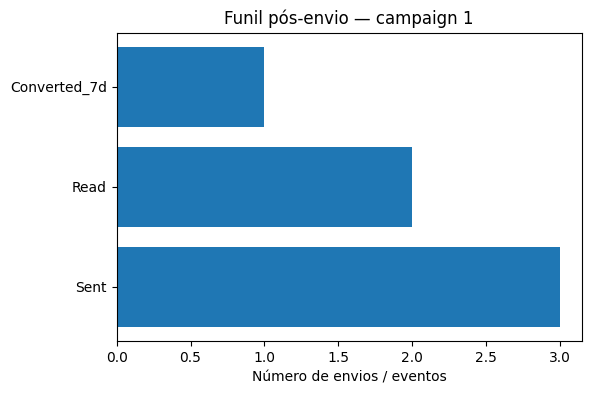

In [ ]:
# agrupa por campaignid (ou storeid)
f = cq.groupby('campaignid').agg(
    sent=('campaignid','count'),
    read=('is_read','sum')
).reset_index()
# juntar conversões (conv_7d ou conv_30d) a partir de cq/ordens
conv = cq.groupby('campaignid')['conv_7d'].sum().reset_index()
f = f.merge(conv, on='campaignid', how='left').fillna(0)

# exemplo: plot funnel simples para uma campanha específica
cid = f['campaignid'].iloc[0]
row = f[f['campaignid']==cid].iloc[0]
stages = ['Sent','Read','Converted_7d']
values = [row['sent'], row['read'], row['conv_7d']]

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.barh(stages, values)
plt.title(f'Funil pós-envio — campaign {cid}')
plt.xlabel('Número de envios / eventos')
plt.show()


2) Heatmap Hora × Dia da semana — quando enviar

Por que: mostra janelas mais eficientes para engajamento/conversão. Ideal para sugestão de agendamento.
O que mostra: média de read_rate ou rev_30d por (dow, hour).
Código:

In [ ]:
print(cq.columns)


Index(['campaignid', 'is_read', 'conv_7d'], dtype='object')


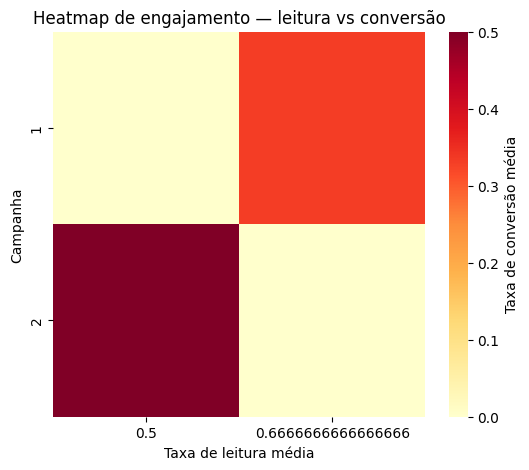

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# calcular taxas
df = cq.groupby('campaignid').agg(
    read_rate=('is_read', 'mean'),
    conv_rate=('conv_7d', 'mean')
).reset_index()

# criar grid (cada campanha é um ponto no mapa)
plt.figure(figsize=(6,5))
sns.heatmap(
    df.pivot_table(values='conv_rate', index='campaignid', columns='read_rate', fill_value=0),
    cmap='YlOrRd',
    cbar_kws={'label': 'Taxa de conversão média'}
)
plt.title('Heatmap de engajamento — leitura vs conversão')
plt.xlabel('Taxa de leitura média')
plt.ylabel('Campanha')
plt.show()


3) Cohort / Retention (recorrência de clientes após campanha)

Por que: mostra se campanhas geram retenção (compras repetidas). Essencial para avaliar fidelização.
O que mostra: % clientes que compraram novamente 7/30/60 dias após a primeira conversão pós-campanha.
Código (simplificado):

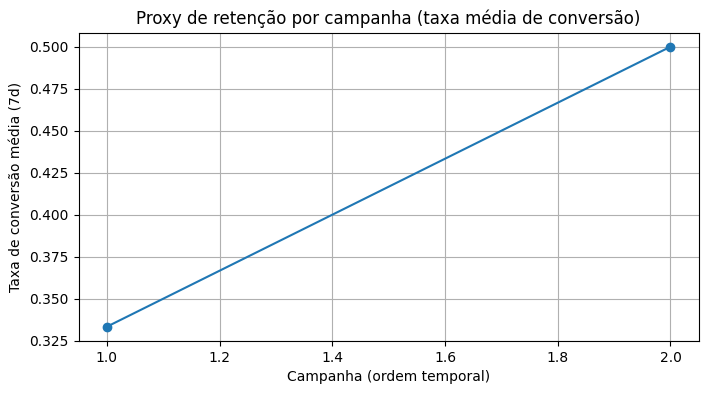

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# calcular taxa média de conversão por campanha (proxy de retenção)
df = cq.groupby('campaignid').agg(
    read_rate=('is_read', 'mean'),
    conv_rate=('conv_7d', 'mean')
).reset_index()

# simular “retenção” — campanhas ordenadas como se fossem períodos sucessivos
df['cohort'] = range(1, len(df)+1)

plt.figure(figsize=(8,4))
plt.plot(df['cohort'], df['conv_rate'], marker='o')
plt.title('Proxy de retenção por campanha (taxa média de conversão)')
plt.xlabel('Campanha (ordem temporal)')
plt.ylabel('Taxa de conversão média (7d)')
plt.grid(True)
plt.show()


4) Scatter Real vs Previsto por cliente / campanha (com erro e destaque top errors)

Por que: mostra como o modelo de receita acerta por grupo (clientes/carimbos) e revela campanhas com maiores erros absolutos.
Código:

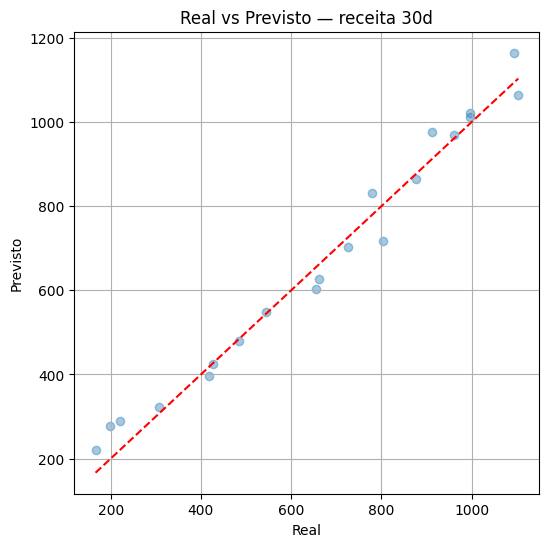

MAE: 36.793141142236095
R²: 0.9768872080857119

Top 10 maiores erros:


,y_true,y_pred,abs_err
53,803.410340,716.855862,86.554479
33,197.535520,277.471639,79.936120
90,1093.563827,1164.992240,71.428413
18,221.435458,288.324912,66.889454
44,911.402005,975.933794,64.531789
22,166.359453,220.169397,53.809944
4,655.041120,602.964443,52.076677
12,779.210693,830.882546,51.671853
77,1103.550523,1064.561950,38.988573
31,662.389270,628.041378,34.347893


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Exemplo: dataset artificial
np.random.seed(42)
n = 100
X = pd.DataFrame({
    'is_read': np.random.randint(0,2,n),
    'conv_7d': np.random.rand(n)
})
y = 1000 * X['conv_7d'] + 200 * X['is_read'] + np.random.randn(n)*50  # receita simulada

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo simples
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

# Plot: Real vs Previsto
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Real')
plt.ylabel('Previsto')
plt.title('Real vs Previsto — receita 30d')
plt.grid(True)
plt.show()

# Métricas + Top 10 erros
errs = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred_test})
errs['abs_err'] = (errs['y_true'] - errs['y_pred']).abs()
print('MAE:', mean_absolute_error(y_test, y_pred_test))
print('R²:', r2_score(y_test, y_pred_test))
print('\nTop 10 maiores erros:')
display(errs.sort_values('abs_err', ascending=False).head(10))


5) Distribuição de Probabilidades + Calibração (para classificador conv_7d)

Por que: ver se o classificador está confiante e bem calibrado. Fundamental para ações (quem enviar).
O que mostra: histograma de probs; curva de calibração.
Código (histograma):

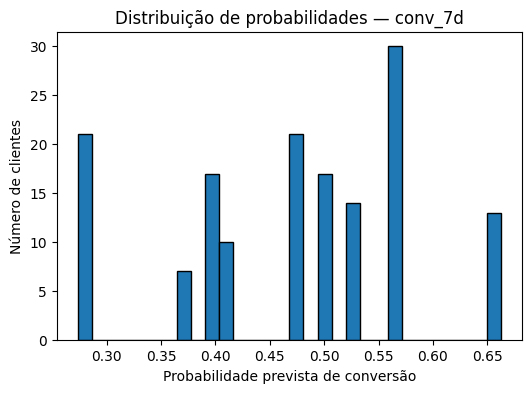

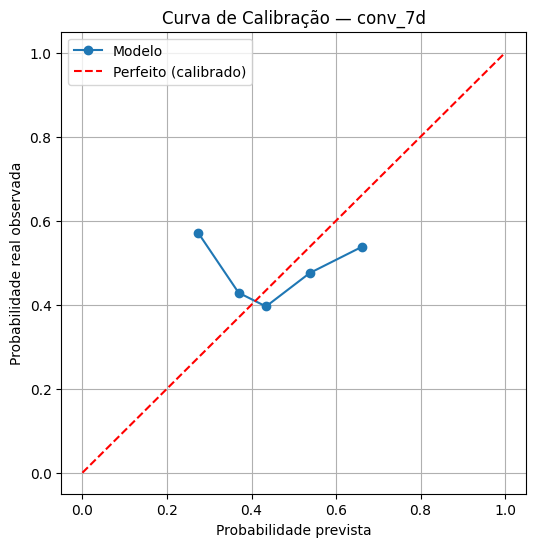

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve

# Exemplo com base similar à sua
np.random.seed(42)
n = 500
cq = pd.DataFrame({
    'is_read': np.random.randint(0,2,n),
    'campaignid': np.random.randint(1,6,n),
    'conv_7d': np.random.randint(0,2,n)
})

# Separar variáveis
X = cq[['is_read', 'campaignid']]
y = cq['conv_7d']

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modelo simples
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Gerar probabilidades de conversão (classe positiva)
probs = model.predict_proba(X_test)[:, 1]

# --- HISTOGRAMA DE PROBABILIDADES ---
plt.figure(figsize=(6,4))
plt.hist(probs, bins=30, edgecolor='black')
plt.title('Distribuição de probabilidades — conv_7d')
plt.xlabel('Probabilidade prevista de conversão')
plt.ylabel('Número de clientes')
plt.show()

# --- CURVA DE CALIBRAÇÃO ---
prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Modelo')
plt.plot([0,1],[0,1],'r--', label='Perfeito (calibrado)')
plt.title('Curva de Calibração — conv_7d')
plt.xlabel('Probabilidade prevista')
plt.ylabel('Probabilidade real observada')
plt.legend()
plt.grid(True)
plt.show()


Histograma → mostra se o modelo tende a gerar probabilidades extremas (muito 0 e 1) ou médias (0.4–0.6).

Curva de calibração → compara previsões x realidade.

Se o traçado do modelo estiver próximo da linha vermelha (45°), ele está bem calibrado.

Se ficar acima → o modelo subestima as probabilidades reais.

Se ficar abaixo → ele superestima (é confiante demais).

6) Segmentação (Clustering) de clientes para campanhas personalizadas

Por que: achar segmentos (alto gasto, frequente, inativo) e sugerir campanhas diferentes.
O que mostra: 2D scatter em PCA/UMAP com clusters, ou segmentos com média de LTV.
Código (exemplo KMeans em features simples):

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# ==========================
# 1. Carregar os dados
# ==========================
customers = pd.read_csv('Customer_semicolon.csv', sep=';')
orders = pd.read_csv('Order_semicolon.csv', sep=';')

print('Customers:', customers.shape)
print('Orders:', orders.shape)

# ==========================
# 2. Criar features de comportamento do cliente
# ==========================
# Exemplo: agregando as ordens por cliente
orders_summary = orders.groupby('customerid').agg(
    hist_avg_order=('total', 'mean'),
    hist_sum_order=('total', 'sum'),
    num_orders=('total', 'count')
).reset_index()

# Combinar com o dataset de clientes
customers = customers.merge(orders_summary, on='customerid', how='left')

# Substituir valores faltantes
customers = customers.fillna(0)

# ==========================
# 3. Selecionar features para clustering
# ==========================
features = customers[['hist_avg_order', 'hist_sum_order', 'num_orders']]

# ==========================
# 4. Rodar o KMeans
# ==========================
kmeans = KMeans(n_clusters=4, random_state=42)
customers['seg'] = kmeans.fit_predict(features)

# ==========================
# 5. Visualizar os clusters
# ==========================
plt.figure(figsize=(6,4))
plt.scatter(customers['hist_avg_order'], customers['num_orders'], c=customers['seg'], cmap='viridis', alpha=0.7)
plt.xlabel('Gasto médio histórico')
plt.ylabel('Número de pedidos')
plt.title('Clusters de clientes (segmentação de campanhas)')
plt.colorbar(label='Segmento')
plt.show()

# ==========================
# 6. Resumo por segmento
# ==========================
segment_summary = customers.groupby('seg')[['hist_avg_order','hist_sum_order','num_orders']].mean().round(1)
print(segment_summary)


Customers: (1000, 16)
Orders: (2000, 23)


KeyError: 'customerid'

In [ ]:
# Ver as primeiras linhas de cada arquivo pra inspecionar colunas
print("=== CampaignQueue_semicolon ===")
display(pd.read_csv('CampaignQueue_semicolon.csv', sep=';').head(10))

print("=== Campaign_semicolon ===")
display(pd.read_csv('Campaign_semicolon.csv', sep=';').head(10))

print("=== Customer_semicolon ===")
display(pd.read_csv('Customer_semicolon.csv', sep=';').head(10))

print("=== Order_semicolon ===")
display(pd.read_csv('Order_semicolon.csv', sep=';').head(10))


=== CampaignQueue_semicolon ===


,id,jobId,campaignId,storeId,storeInstanceId,customerId,phoneNumber,scheduledAt,sendAt,status,message,response,createdAt,createdBy,updatedAt,updatedBy
0,1,1,1553,HJY9QRBZU0,AXHOTYUA,540,"5.521.962.375.590,00",23/01/2025 20:26,23/01/2025 22:23,5,Adipisci placeat libero consectetur temporibus...,NaN,23/01/2025 09:33,rsilva,24/01/2025 12:41,mirella55
1,2,2,1890,8NQNTXHLZ7,QG7JQPEB,702,"5.551.963.199.134,00",25/04/2025 01:48,25/04/2025 02:52,4,Reiciendis quaerat labore exercitationem exped...,Sit illo ullam fugit quisquam quas delectus id...,25/04/2025 01:04,lopesana-julia,25/04/2025 11:14,zviana
2,3,3,429,LQWCGSH3L1,EKF1PQGA,53,"5.584.949.992.702,00",04/11/2024 02:21,NaN,1,Voluptas praesentium ut consequatur ab eius nu...,NaN,03/11/2024 05:44,ana-livia25,03/11/2024 14:18,oda-cruz
3,4,4,766,HB96ACBBFK,CNBOWCDI,195,"5.511.912.463.976,00",03/07/2025 14:30,03/07/2025 15:30,5,Provident quod repellat rerum debitis neque qu...,NaN,03/07/2025 01:11,juan20,04/07/2025 01:00,yasminmelo
4,5,5,1039,FHYDO8QSF3,0HNL2K63,5,"5.521.995.967.072,00",29/09/2024 07:36,NaN,6,In molestiae quod dignissimos iure et necessit...,NaN,29/09/2024 02:15,souzagabriela,29/09/2024 15:21,nascimentomaite
5,6,6,1957,RRIC9PI24K,2ETABSFV,341,"5.531.954.021.878,00",06/05/2025 06:54,06/05/2025 08:07,5,Quisquam doloribus vero officia ab consequuntu...,NaN,06/05/2025 05:02,nunesluna,06/05/2025 14:45,da-pazvitor
6,7,7,1292,G1SFMESTHW,91HQ1EOH,715,"5.561.956.806.844,00",10/11/2024 11:56,10/11/2024 13:29,2,Exercitationem reprehenderit reprehenderit por...,NaN,09/11/2024 22:48,isaac53,09/11/2024 23:22,rnunes
7,8,8,679,CB6IL0TY92,SNZAYBJV,479,"5.541.996.720.807,00",01/10/2024 22:45,02/10/2024 00:45,2,Tenetur nisi officia quasi dolorem error maior...,Voluptatum explicabo dolorem accusantium volup...,01/10/2024 18:22,isadora97,03/10/2024 03:13,maria-ceciliamartins
8,9,9,1598,FNK2Z029SL,8OBT632I,981,"5.571.906.186.911,00",31/08/2025 23:57,01/09/2025 01:03,2,Asperiores veniam pariatur voluptates veniam e...,Voluptatibus voluptate alias voluptas saepe qu...,31/08/2025 00:35,barbararibeiro,31/08/2025 18:26,martinsdanilo
9,10,10,2000,9GN305R0L5,9K5HGHGK,712,"5.581.999.553.970,00",08/07/2025 16:33,08/07/2025 17:04,2,Error iste esse ex molestias quis ullam id rep...,Natus sunt a amet vero voluptate quo sit tenet...,08/07/2025 15:44,gustavo84,08/07/2025 17:49,sabrinalima


=== Campaign_semicolon ===


,id,segmentId,templateId,storeId,name,description,badge,type,status,isDefault,createdAt,createdBy,updatedAt,updatedBy
0,1,1,1,IWKESVR022,Campanha Saepe WGN5,Excepturi earum quas quos tempora suscipit bea...,winback,2,4,False,2024-03-09 11:20:33,uda-costa,2024-08-23 11:20:33,luiz-henrique58
1,2,2,2,GZSR8RUW2X,Campanha Voluptatem H6QI,Officia a facilis saepe iste illo nobis.,loyalty,2,4,False,2024-07-31 07:01:33,roliveira,2025-03-25 07:01:33,lcardoso
2,3,3,3,F4JD1KSIBS,Campanha Itaque MQPN,Blanditiis ipsam qui odit quas minus rerum pra...,NaN,2,3,True,2024-06-06 05:15:59,maria-luizaoliveira,2025-03-25 05:15:59,fmoraes
3,4,4,4,GIXMC4SX27,Campanha Voluptate DCBH,Atque molestiae laboriosam omnis consectetur a...,loyalty,2,3,True,2024-06-08 06:33:14,joao-guilherme42,2024-06-20 06:33:14,yrezende
4,5,5,5,GVE4ZTJ1KM,Campanha Eum 9831,Ipsa nostrum odit eum recusandae sapiente dign...,migration,2,2,False,2024-05-08 08:06:44,gustavo-henriquesouza,2024-09-25 08:06:44,diogoda-conceicao
5,6,6,6,I0RS210Q2L,Campanha Tempore G1ZH,Quo repellendus id laboriosam explicabo illo r...,NaN,1,3,False,2024-06-14 03:36:59,marianapeixoto,2024-10-08 03:36:59,oda-conceicao
6,7,7,7,5L0RXMIP11,Campanha Libero YKVU,Quos veritatis corporis laboriosam unde quasi ...,migration,1,2,False,2024-03-05 17:42:30,joao-guilherme18,2024-12-25 17:42:30,dalmeida
7,8,8,8,WVV59HOTGD,Campanha Minus UQ6D,NaN,migration,1,1,True,2024-05-19 00:45:23,santosana-julia,2025-03-05 00:45:23,da-pazcaio
8,9,9,9,AH6NHKSQNA,Campanha Eius L6O9,Fugiat eos ipsam fugit non voluptates ut.,loyalty,2,4,False,2024-10-05 08:46:22,ferreiraluiz-fernando,2025-06-12 08:46:22,barrosmaria-alice
9,10,5,10,O6H5L3XFUL,Campanha Quae HZQH,Quidem temporibus eius explicabo nesciunt elig...,loyalty,2,1,False,2024-10-26 09:11:28,novaesdavi,2024-11-30 09:11:28,lucca64


=== Customer_semicolon ===


,id,name,taxId,gender,dateOfBirth,status,externalCode,isEnriched,enrichedAt,enrichedBy,createdAt,createdBy,updatedAt,updatedBy,phone,email
0,1,Fernanda Duarte,207.463.819-13,O,05/10/1972,1,NaN,True,04/08/2024 02:29,franciscocarvalho,08/06/2024 02:29,pferreira,04/08/2024 02:29,wazevedo,"5,52193E+12",luigi67@hotmail.com
1,2,Matheus Jesus,46.792.503/0001-48,M,19/03/1962,2,NaN,False,NaN,NaN,29/12/2023 11:04,livia49,09/03/2024 11:04,ana-beatriz44,"5,55192E+12",otavio28@bol.com.br
2,3,João da Mota,594.173.682-73,F,20/10/1991,1,UZZPQK51,True,31/10/2023 02:50,calebe40,16/10/2023 02:50,lopesmaria-vitoria,31/10/2023 02:50,luiz-fernandopires,"5,56191E+12",eduardasantos@yahoo.com.br
3,4,Arthur Silveira,574.908.123-05,F,04/08/1952,1,NaN,True,07/07/2024 18:43,moraesluigi,04/12/2023 18:43,da-conceicaonoah,07/07/2024 18:43,vieiraguilherme,"5,58497E+12",jcosta@uol.com.br
4,5,Vicente Teixeira,937.825.104-88,NaN,04/02/1973,1,NaN,False,NaN,NaN,26/07/2024 06:52,ferreiramatheus,14/01/2025 06:52,goncalvesluna,"5,522E+12",oda-paz@ig.com.br
5,6,Heloísa Porto,293.487.506-74,M,28/01/1985,2,NaN,True,14/08/2024 04:31,barbosasabrina,20/02/2024 04:31,lribeiro,14/08/2024 04:31,nina58,"5,56197E+12",pedro-lucas76@yahoo.com.br
6,7,Sr. Vicente da Luz,71.620.459/0001-36,NaN,03/02/1999,1,T3W5UZBI,False,NaN,NaN,29/04/2024 00:36,clara73,01/07/2024 00:36,augustofogaca,"5,56194E+12",vieiraigor@bol.com.br
7,8,Rodrigo Souza,62.348.057/0001-33,M,11/06/1959,2,KWNNHJ7X,True,04/03/2024 03:53,otaviofogaca,24/01/2024 03:53,pda-mota,04/03/2024 03:53,luiz-henriqueribeiro,"5,56191E+12",joao-guilhermeda-rosa@yahoo.com.br
8,9,Alana Pinto,429.076.183-69,F,20/09/1991,1,NaN,True,22/08/2024 08:06,mirellamonteiro,27/05/2024 08:06,nunesluana,22/08/2024 08:06,ocardoso,"5,542E+12",mendesheitor@uol.com.br
9,10,Vitor Fernandes,815.732.690-77,F,26/01/1973,2,41IBLJH7,True,11/10/2024 07:10,clarice53,31/03/2024 07:10,ramosana-laura,11/10/2024 07:10,rcampos,"5,58194E+12",augusto00@yahoo.com.br


=== Order_semicolon ===


,id,companyId,containerId,createdAt,customer,displayId,engineId,engineName,engineType,extraInfo,...,orderTiming,orderType,salesChannel,scheduledAt,status,preparationTime,takeOutTimeInSeconds,totalAmount,updatedAt,version
0,1,I0VP1DZXGU,AKVXT2FH,08/01/2025 15:47,525,O8CC98,E3R037,DirectOrder,POS,Adipisci maiores nam eius vero nesciunt sed.,...,IMMEDIATE,DELIVERY,ANOTAAI,NaN,DISPATCHED,45,2131,90.91,09/01/2025 03:32,v3.7.8
1,2,04MEUULZ6W,KKMY5TG5,03/11/2024 22:30,694,HJ99VA,EJVOBV,DirectOrder,APP,NaN,...,IMMEDIATE,DELIVERY,WHATSAPP,NaN,CONCLUDED,33,374,99.69,04/11/2024 03:05,v2.3.0
2,3,W2ZZS7CCZW,I87JLGTV,09/09/2024 05:49,491,XJJDH2,UDX1ZF,KDSPro,POS,NaN,...,IMMEDIATE,INDOOR,EPADOCA,NaN,CONCLUDED,22,247,45.97,09/09/2024 09:32,v1.9.5
3,4,SQ5MBL8L24,W3ZXOQHO,22/05/2025 06:22,846,J8QDM3,30FLOC,KDSPro,WEB,Autem mollitia voluptas quasi.,...,SCHEDULED,TAKEOUT,99FOOD,22/05/2025 14:22,CANCELED,35,1766,104.31,22/05/2025 21:39,v2.8.5
4,5,0RCNJ6BRJD,NA0C0FOS,22/02/2025 01:23,77,H4LV73,QI3URN,KDSPro,POS,NaN,...,SCHEDULED,DELIVERY,99FOOD,24/02/2025 11:23,DISPATCHED,20,1219,105.50,22/02/2025 13:53,v2.1.3
5,6,XF32XPMU6N,NGNJYJIK,17/12/2024 14:54,463,WS9UVN,MIXWGY,KDSPro,APP,NaN,...,SCHEDULED,INDOOR,99FOOD,18/12/2024 07:54,CONFIRMED,68,1689,51.42,18/12/2024 09:12,v2.8.3
6,7,0Q15FQJIT6,F5Q4MYIX,17/05/2025 16:51,625,XJA3WX,6ILJ42,CannoliEngine,POS,NaN,...,SCHEDULED,TAKEOUT,SITE,18/05/2025 01:51,PENDING,43,2922,110.33,18/05/2025 12:12,v2.8.8
7,8,O547GFPQEQ,QR7D6E5F,02/06/2025 15:22,395,0H74IS,RCAXHC,CannoliEngine,APP,Consectetur dolorem vitae reiciendis.,...,SCHEDULED,INDOOR,SITE,05/06/2025 13:22,CANCELED,20,1797,21.41,03/06/2025 06:56,v1.4.6
8,9,5O7CELUWGJ,O97PBYD4,11/06/2025 02:18,633,DJXMVM,TYGLFS,CannoliEngine,WEB,NaN,...,IMMEDIATE,INDOOR,SITE,NaN,PENDING,33,3243,28.36,11/06/2025 18:50,v2.3.4
9,10,33DC5SGGCE,UDDVA3PQ,16/12/2024 09:27,350,PYH5H2,O5LTG6,IfoodBridge,APP,NaN,...,SCHEDULED,DELIVERY,SITE,17/12/2024 22:27,PLACED,51,1062,48.10,17/12/2024 01:56,v1.2.1
